In [1]:
import pandas as pd
import numpy as np
# from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_rows', None)     # show all rows
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', None)        # no fixed width wrapping
pd.set_option('display.max_colwidth', None) # show full cell content

In [2]:
def peek_df(df, target_col=None):
    print("="*40)
    print("HEAD OF DATAFRAME")
    print("="*40)
    if df.shape[1] > 5:
        print(df.iloc[:, :5].head())
    else:
        print(df.head())

    print("="*40)
    print("SHAPE OF DATAFRAME")
    print("="*40)
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")

    print("="*40)
    print("INFO")
    print("="*40)
    df.info()
    print()

    print("="*40)
    print("MISSING VALUES")
    print("="*40)
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if not missing.empty:
        missing_percent = (missing / len(df)) * 100
        missing_df = pd.DataFrame({
            "Missing Values": missing,
            "Percent": missing_percent.round(2)
        })
        print(missing_df, "\n")
    else:
        print("No missing values.\n")

    print("="*40)
    print("DESCRIPTIVE STATS (NUMERIC)")
    print("="*40)
    print(df.describe(), "\n")

    print("="*40)
    print("DESCRIPTIVE STATS (CATEGORICAL)")
    print("="*40)
    categorical_cols = df.select_dtypes(include='object').columns
    if len(categorical_cols) > 0:
        print(df[categorical_cols].describe(), "\n")
    else:
        print("No categorical (object) columns to describe.\n")

    print("="*40)
    print("UNIQUE VALUES")
    print("="*40)
    for col in df.columns:
        if df[col].nunique(dropna=True) <= 20:
            print(f"{col}: {df[col].unique()}")

    if target_col:
        print("="*40)
        print(f"TARGET COLUMN DISTRIBUTION: {target_col}")
        print("="*40)
        print(df[target_col].value_counts(), "\n")

        sns.countplot(x=target_col, data=df)
        plt.title(f"Countplot of '{target_col}'")
        plt.show()

        if df.shape[1] <= 35:
            print("="*40)
            print("CORRELATION HEATMAP (NUMERIC FEATURES)")
            print("="*40)
            numeric_df = df.select_dtypes(include=['number'])
            sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm", fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.show()

In [3]:
# Read the training and test datasets
df_raw_train = pd.read_csv('../datasets/vaastav/2024_2025/fpl_data_all_gw.csv')

In [4]:
# def pick_gw(df, gw):
#     common_cols = [col for col in df.columns if not col.startswith('gw')]
#     gw_cols = [col for col in df.columns if col.startswith(f'gw{gw}_')]
#     selected_cols = common_cols + gw_cols
#     return df[selected_cols].copy()

In [5]:
# # Specify the game week number
# gw_num = 1
# target_col = f'gw{gw_num}_total_points'
# df_gw = pick_gw(df_raw_train, gw_num)

In [6]:
# drop a few columns
df_raw_train.drop(columns=['element', 'name', 'team'], inplace=True)
gw_cols_to_drop = ['fixture', 'opponent_team', 'value']
for gw_num in range(1, 39):
    df_raw_train.drop(columns=[f'gw{gw_num}_{col}' for col in gw_cols_to_drop], inplace=True)

In [7]:
# split target from features
target_col = 'position'

# one-hot encode target
y = df_raw_train[[target_col]].copy()

# remove target out of features and convert all columns to float
X = df_raw_train.drop(columns=[target_col])

# standard scale features
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# convert to float
X = X.astype(float).copy()

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8, stratify=y)

# one-hot encode y
onehot_encoder = OneHotEncoder(sparse_output=False, dtype=int)
y_train = onehot_encoder.fit_transform(y_train)
y_test = onehot_encoder.transform(y_test)

# insert bias term in X
X_train.insert(0, 'bias', 1)
X_test.insert(0, 'bias', 1)

In [8]:
# Cross-entropy loss function
def cross_entropy_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

# Accuracy calculation
def accuracy(y_true, y_pred_probs):
    preds = np.argmax(y_pred_probs, axis=1)
    true_labels = np.argmax(y_true, axis=1)
    return np.mean(preds == true_labels)

In [9]:
X_train.values[0,:]

array([ 1.        , -1.33443901, -0.604047  , ..., -0.23039573,
       -0.25662791, -0.20584674])

In [10]:
# Batch GD for softmax regression 

# params
k = y_train.shape[1]        # number of classes
n = X_train.shape[0]        # number of training examples
d = X_train.shape[1] - 1    # don't count bias term

# initialize
theta = np.zeros([k, d+1])
alpha = 0.0001
num_iterations = 100

# batch GD
theta_history = np.zeros([num_iterations+1, k, d+1])
theta_history[0] = theta

train_loss_history = []
train_acc_history = []  
val_loss_history = []
val_acc_history = []

for iter in range(num_iterations):

    # GD step
    z = X_train.values @ theta.T
    prediction = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)       # softmax step
    error = prediction - y_train
    gradient = error.T @ X_train.values
    theta -= alpha * gradient

    # history
    theta_history[iter + 1] = theta

    # Track metrics
    loss = cross_entropy_loss(y_train, prediction)
    acc = accuracy(y_train, prediction)
    train_loss_history.append(loss)
    train_acc_history.append(acc)

    # Validation forward pass
    z_test = X_test.values @ theta.T
    prediction_val = np.exp(z_test - np.max(z_test, axis=1, keepdims=True))
    prediction_val /= np.sum(prediction_val, axis=1, keepdims=True)

    # Track validation metrics
    val_loss = cross_entropy_loss(y_test, prediction_val)
    val_acc = accuracy(y_test, prediction_val)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)


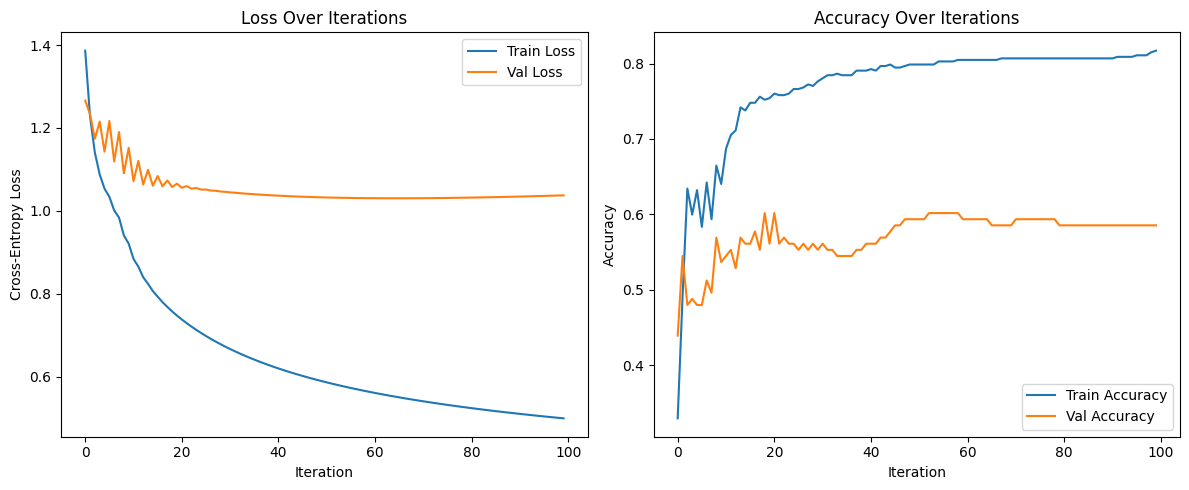

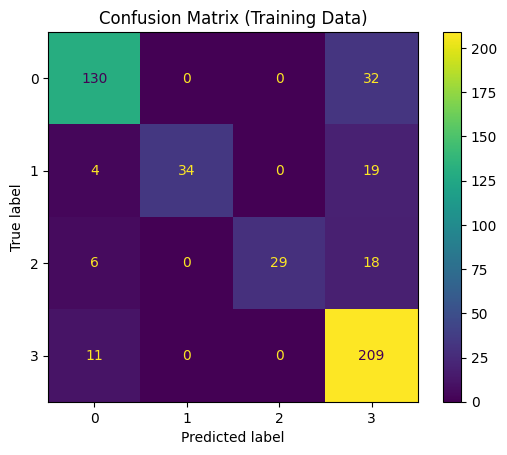

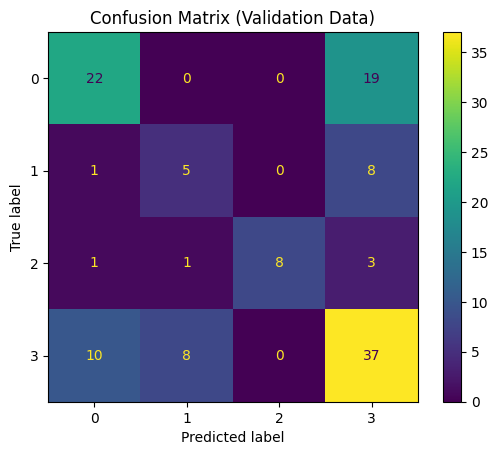

Confusion Matrix (Validation Data):
[[22  0  0 19]
 [ 1  5  0  8]
 [ 1  1  8  3]
 [10  8  0 37]]


In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.title('Loss Over Iterations')

plt.subplot(1,2,2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Iterations')

plt.tight_layout()
plt.show()

# # --- Plot Parameter Trajectories ---
# plt.figure(figsize=(10,6))
# for class_idx in range(k):
#     for feature_idx in range(d + 1):
#         plt.plot(theta_history[:, class_idx, feature_idx], label=f'Class {class_idx} Feature {feature_idx}')
# plt.xlabel("Iteration")
# plt.ylabel("Theta Value")
# plt.title("Parameter Trajectories During Training")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# --- Confusion Matrix ---
# Training data
z_final = X_train.values @ theta.T
exp_z_final = np.exp(z_final - np.max(z_final, axis=1, keepdims=True))
pred_final = exp_z_final / np.sum(exp_z_final, axis=1, keepdims=True)
pred_labels = np.argmax(pred_final, axis=1)
true_labels = np.argmax(y_train, axis=1)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Training Data)")
plt.show()

# Validation data
z_final = X_test.values @ theta.T
exp_z_final = np.exp(z_final - np.max(z_final, axis=1, keepdims=True))
pred_final = exp_z_final / np.sum(exp_z_final, axis=1, keepdims=True)
pred_labels = np.argmax(pred_final, axis=1)
true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Validation Data)")
plt.show()

print("Confusion Matrix (Validation Data):")
print(cm)

In [12]:
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.4f}")  

Accuracy: 0.5854


In [13]:
# Class labels
classes = onehot_encoder.categories_[0]

# Accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"\nOverall Accuracy: {accuracy:.4f}\n")

# Precision, Recall, F1 for each class
print("Per-class metrics:")
metrics = []
for i, cls in enumerate(classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics.append([cls, TP, precision, recall, f1])
    print(f"{cls}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# Macro averages
avg_precision = np.mean([m[2] for m in metrics])
avg_recall = np.mean([m[3] for m in metrics])
avg_f1 = np.mean([m[4] for m in metrics])
print("\nMacro Averages:")
print(f"Precision={avg_precision:.4f}, Recall={avg_recall:.4f}, F1={avg_f1:.4f}")


Overall Accuracy: 0.5854

Per-class metrics:
DEF: Precision=0.6471, Recall=0.5366, F1=0.5867
FWD: Precision=0.3571, Recall=0.3571, F1=0.3571
GK: Precision=1.0000, Recall=0.6154, F1=0.7619
MID: Precision=0.5522, Recall=0.6727, F1=0.6066

Macro Averages:
Precision=0.6391, Recall=0.5455, F1=0.5781
